## MOIRAI Usage Example

### Key features of the model:
- **Multi-patch Layers:** Adapts to different granularities (frequencies) - different patch size for each granularity
- **Probabilistic:** Predicts params of mix of distributions along with a confidence score for each distribution

### Loading MOIRAI Model

In [1]:
# External imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

# Local imports
from samay.dataset import MoiraiDataset
from samay.model import MoiraiTSModel
from samay.utils import visualize, read_yaml, prep_finetune_config

# Load the pretrained model
repo = "Salesforce/moirai-moe-1.0-R-small"
config = {
        "context_len": 128,
        "horizon_len": 64,
        "num_layers": 100,
        "model_type": "moirai-moe",
        "model_size": "small"
    }

moirai_model = MoiraiTSModel(repo=repo, config=config)

### Define the datasets

In [2]:
# Config for the electric transformer temperature dataset
data_config = {"name" : "Etth1",
                "path" : "../src/samay/models/moment/data/ETTh1.csv",
                "date_col" : "date",
                "freq": "h"
            }

df = pd.read_csv(data_config["path"])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Here, we have 6 input features (all form `input_ts`) and the target column is the *Oil Temperature* (`OT`)

In [3]:
# test dataset - for zero-shot forecasting
test_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="test",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
)

Normalizing the dataset


### Evaluate zero-shot forecasting

In [4]:
a = np.random.random((1,4,10))
len(a.shape)

3

In [5]:
%%time
metrics, trues, preds, histories = moirai_model.evaluate(test_dataset)
print(metrics)

Forecasting done....now testing
{'mse': 0.5565837068410011, 'mae': 0.4878751595454871, 'mase': 1.7776931057677585, 'mape': 0.7628517326992671, 'rmse': 0.7182149269841657, 'nrmse': 0.12329912918504495, 'smape': 0.8062650879776672, 'msis': 0.1051555555184134, 'nd': 4.49031081361038, 'mwsq': 0.07994499641810597, 'crps': 0.8318343763552117}
CPU times: user 21.9 s, sys: 279 ms, total: 22.2 s
Wall time: 23 s


### Visualise forecast for a given window

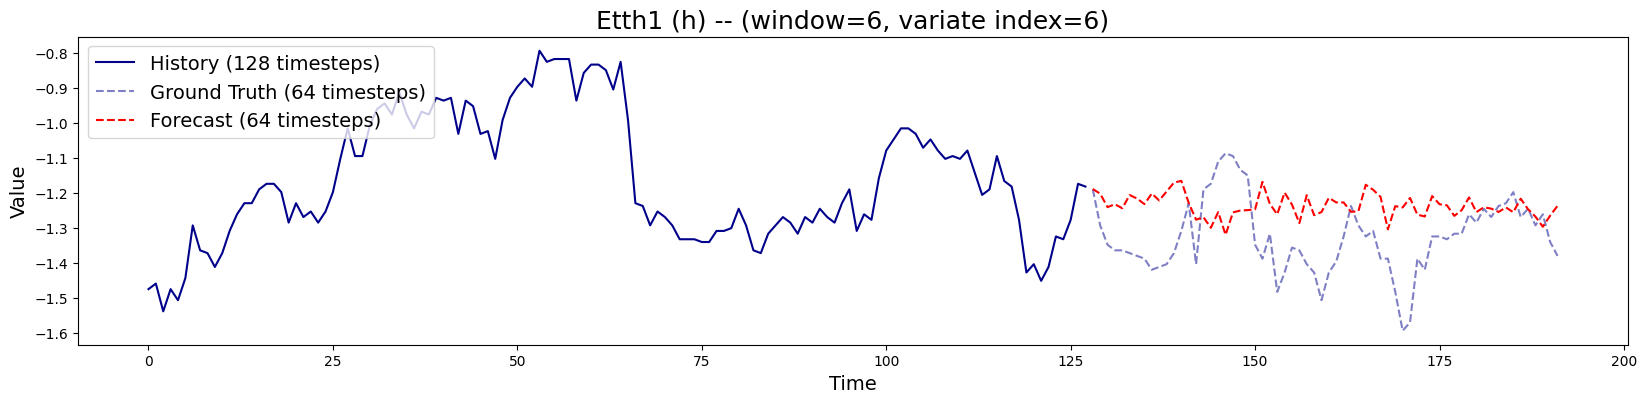

In [6]:
select = {"dataset":data_config["name"], "freq":data_config["freq"]}
visualize(context_len=config["context_len"], trues=trues, preds=preds, history=histories,figsize=(20,4),**select)

### Finetune MOIRAI on ETT Dataset

In [7]:
path = "../src/samay/models/uni2ts/cli/conf/finetune/model/moirai_small.yaml"
fin_config = read_yaml(path)

fin_config.keys()

dict_keys(['_target_', 'module_kwargs', 'min_patches', 'min_mask_ratio', 'max_mask_ratio', 'max_dim', 'loss_func', 'val_metric', 'lr', 'weight_decay', 'beta1', 'beta2', 'num_training_steps', 'num_warmup_steps', 'checkpoint_path'])

In [8]:
data_config_path = "../src/samay/models/uni2ts/cli/conf/finetune/default.yaml"
torch_config = read_yaml(data_config_path)
ft_kwargs = prep_finetune_config(data_config_path)

In [9]:
# Number of input features to Input projection layer is the patch size used by the model
patch_size = moirai_model.model.module.in_proj.in_features_ls[0]
patch_size

16

In [10]:
# Train dataset
train_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="train",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
    patch_size=patch_size,
    kwargs=torch_config["train_dataloader"]
)

Normalizing the dataset


Epoch 0: Loss: -4.690
Epoch 1: Loss: -4.893
Epoch 2: Loss: -5.015
Epoch 3: Loss: -5.090
Epoch 4: Loss: -5.160
Finetuning done
Fineuned model updated
CPU times: user 21min 39s, sys: 2min 47s, total: 24min 27s
Wall time: 27min 18s


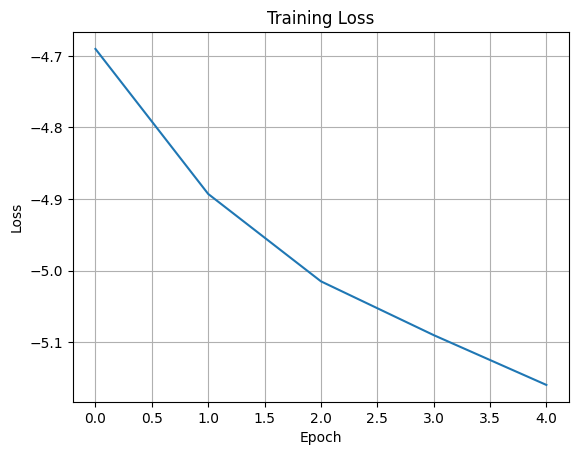

In [11]:
%%time
moirai_model.finetune(train_dataset, **ft_kwargs)

### Evaluate finetuned model

In [12]:
%%time
metrics, trues, preds, histories = moirai_model.evaluate(test_dataset,zero_shot=False)
print(metrics)

Forecasting done....now testing
{'mse': 0.5779918631464251, 'mae': 0.4894990296919897, 'mase': 1.7793430057494721, 'mape': 0.8081392584103635, 'rmse': 0.7267978189638105, 'nrmse': 0.12445993317981198, 'smape': 0.7968593254384336, 'msis': 0.10380481506645091, 'nd': 4.7801035900792135, 'mwsq': 0.09674482338920819, 'crps': 0.7804203160988368}
CPU times: user 20.3 s, sys: 97.4 ms, total: 20.4 s
Wall time: 21.1 s


### Visualise forecast for a given window

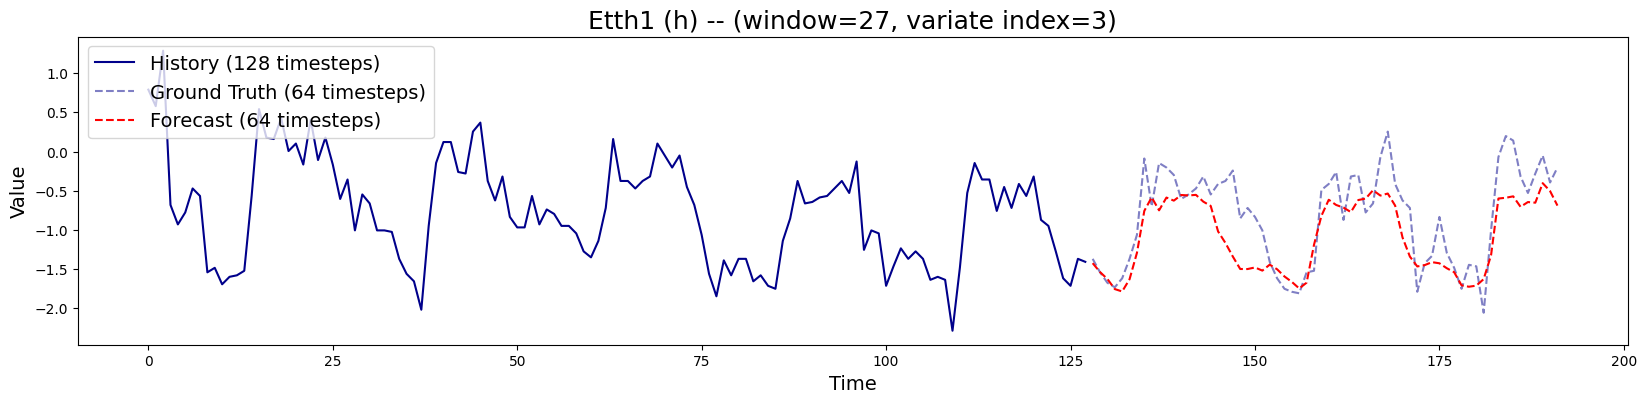

In [13]:
visualize(context_len=config["context_len"], trues=trues, preds=preds, history=histories,figsize=(20,4),**select)